In [1]:
import pandas as pd
import math
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split,KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge

### Data Prep for Q1,Q2,Q3

In [2]:
data_file='C:/Users/Riya/Dropbox/March onwards/Python Data Science/Data/Existing Base.csv'
bd=pd.read_csv(data_file)

bd.loc[bd["children"]=="Zero","children"]="0"
bd.loc[bd["children"]=="4+","children"]="4"
bd["children"]=pd.to_numeric(bd["children"],errors="coerce")


bd["y"]=np.where(bd["Revenue Grid"]==2,0,1)
bd=bd.drop(["Revenue Grid"],1)


for i in range(len(bd)):
    if bd["age_band"][i] in ["71+","65-70","51-55","45-50"]:
        bd.loc[i,"age_band"]="ab_10"
    if bd["age_band"][i] in ["55-60","41-45","31-35","22-25","26-30"]:
        bd.loc[i,"age_band"]="ab_11"
    if bd["age_band"][i]=="36-40":
        bd.loc[i,"age_band"]="ab_13"
    if bd["age_band"][i]=="18-21":
        bd.loc[i,"age_band"]="ab_17"
    if bd["age_band"][i]=="61-65":
        bd.loc[i,"age_band"]="ab_9"
ab_dummies=pd.get_dummies(bd["age_band"])

bd=pd.concat([bd,ab_dummies],1)
bd=bd.drop(["age_band","Unknown"],1)


bd["st_partner"]=np.where(bd["status"]=="Partner",1,0)
bd["st_singleNm"]=np.where(bd["status"]=="Single/Never Married",1,0)
bd["st_divSep"]=np.where(bd["status"]=="Divorced/Separated",1,0)
bd=bd.drop(["status"],1)


for i in range(len(bd)):
    if bd["occupation"][i] in ["Unknown","Student","Secretarial/Admin","Other","Manual Worker"]:
        bd.loc[i,"occupation"]="oc_11"
    if bd["occupation"][i] in ["Professional","Business Manager"]:
        bd.loc[i,"occupation"]="oc_12"
    if bd["occupation"][i]=="Retired":
        bd.loc[i,"occupation"]="oc_10"
oc_dummies=pd.get_dummies(bd["occupation"])

bd=pd.concat([bd,oc_dummies],1)

bd=bd.drop(["occupation","Housewife"],1)

bd["ocp_10"]=0
bd["ocp_12"]=0
for i in range(len(bd)):
    if bd["occupation_partner"][i] in ["Unknown","Retired","Other"]:
        bd.loc[i,"ocp_10"]=1
    if bd["occupation_partner"][i] in ["Student","Secretarial/Admin"]:
        bd.loc[i,"ocp_12"]=1
        
bd=bd.drop(["occupation_partner"],1)


bd.drop(["post_area","post_code"],axis=1,inplace=True)


for i in range(len(bd)):
    if bd["TVarea"][i] in ["Meridian","TV South West","Tyne Tees"]:
        bd.loc[i,"TVarea"]="TV_9"
    if bd["TVarea"][i] in ["Grampian","HTV"]:
        bd.loc[i,"TVarea"]="TV_10"
    if bd["TVarea"][i] in ["Anglia","Carlton","Central","Scottish TV"]:
        bd.loc[i,"TVarea"]="TV_11"
    if bd["TVarea"][i] in ["Ulster","Unknown","Yorkshire","Granada"]:
        bd.loc[i,"TVarea"]="TV_12"
bd_dummies=pd.get_dummies(bd["TVarea"])


bd=pd.concat([bd,oc_dummies],axis=1)
bd.drop(["TVarea","Border"],axis=1,inplace=True)

bd.drop(['region'],axis=1,inplace=True)


bd["hs_own"]=np.where(bd["home_status"]=="Own Home",1,0)
del bd["home_status"]


bd["gender_f"]=np.where(bd["gender"]=="Female",1,0)
del bd["gender"]

bd["semp_yes"]=np.where(bd["self_employed"]=="Yes",1,0)
del bd["self_employed"]


bd["semp_part_yes"]=np.where(bd["self_employed_partner"]=="Yes",1,0)
del bd["self_employed_partner"]



bd["fi"]=4 
bd.loc[bd["family_income"]=="< 8,000, >= 4,000","fi"]=6
bd.loc[bd["family_income"]=="<10,000, >= 8,000","fi"]=9
bd.loc[bd["family_income"]=="<12,500, >=10,000","fi"]=11.25
bd.loc[bd["family_income"]=="<15,000, >=12,500","fi"]=13.75
bd.loc[bd["family_income"]=="<17,500, >=15,000","fi"]=16.25
bd.loc[bd["family_income"]=="<20,000, >=17,500","fi"]=18.75
bd.loc[bd["family_income"]=="<22,500, >=20,000","fi"]=21.25
bd.loc[bd["family_income"]=="<25,000, >=22,500","fi"]=23.75
bd.loc[bd["family_income"]=="<27,500, >=25,000","fi"]=26.25
bd.loc[bd["family_income"]=="<30,000, >=27,500","fi"]=28.75
bd.loc[bd["family_income"]==">=35,000","fi"]=35
bd=bd.drop(["family_income"],1)



bd.drop(['Tvarea'],1,inplace=True)


In [3]:
bd.dropna(axis=0,inplace=True)
bd_train, bd_test = train_test_split(bd, test_size = 0.2,random_state=2)

x_train=bd_train.drop(["y","REF_NO"],1)
y_train=bd_train["y"]

x_test=bd_test.drop(["y","REF_NO"],1)
y_test=bd_test["y"]

x_train.index=[x for x in range(len(x_train))]
y_train.index=[x for x in range(len(x_train))]


## Question1

Build logistic regression model with l1 penalty and best value of penalty C. Find out auc score on test data for the same.

In [6]:
#finding out the best parameter for logistic using l1 penalty
C_param =[0.0001,0.0002,0.0005,0.001,0.005,0.01,0.05, 0.1,0.5, 1, 10, 100,500,1000] 
auc_10cv=[]
for c in C_param:
    logr=LogisticRegression(C=c,penalty="l1",class_weight="balanced",random_state=2)
    kf = KFold(len(x_train), n_folds=10)
    score_c=0
    for train, test in kf:
        logr.fit(x_train.loc[train], y_train[train])
        score_c+=roc_auc_score(y_train,logr.predict(x_train))
    auc_10cv.append(score_c/10)
    print('{:.3f}\t {:.5f}\t '.format(c,score_c/10))
C_param=np.array(C_param)
auc_10cv=np.array(auc_10cv)
best_c=C_param[auc_10cv==max(auc_10cv)][0]
print('Value of C with max AUC score:',max(auc_10cv),' for 10 fold CV is :',best_c )

Value of C with max AUC score: 0.906841576244  for 10 fold CV is : 1.0


In [7]:
logr=LogisticRegression(C=best_c,penalty="l1",class_weight="balanced",random_state=2)

In [8]:
logr.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=2,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [9]:
roc_auc_score(y_test,logr.predict(x_test))

0.89959186496956278

## Question 2. 

For l1 penalty plot a graph showing how number of variables with coefficient 0 increase with decreasing
C parameter and on the same graph also show how auc score on test data decreases with decreasing C parameter.

In [10]:
coef_zero=[]
a_score=[]
C_param=[0.0001,0.0002,0.0005,0.001,0.005,0.01,0.05, 0.1,0.5, 1, 10, 100,500,1000] 
for c in C_param:
    logr=LogisticRegression(C=c,penalty="l1",class_weight="balanced",random_state=2)
    logr.fit(x_train,y_train)
    coef=logr.coef_
    var_zero=(coef==0).sum()
    coef_zero.append(var_zero)
    score=roc_auc_score(y_test,logr.predict(x_test))
    a_score.append(score)
    
    
validation=pd.DataFrame(list(zip(np.log(C_param),coef_zero,a_score)),
                        columns=["C_param","variables_with_coef_zero","auc_score"])



,C_param,variables_with_coef_zero,auc_score
0,0.0001,31,0.842165
1,0.0002,29,0.868379
2,0.0005,28,0.882030
3,0.0010,27,0.890959
4,0.0050,25,0.894316
5,0.0100,25,0.894316
6,0.0500,19,0.892361
7,0.1000,17,0.893744
8,0.5000,6,0.897083
9,1.0000,5,0.899592


Log of c parameter is taken so as down the scale. 

In [14]:
from ggplot import *
%matplotlib inline

C:\Users\Riya\AppData\Local\Continuum\Anaconda3\lib\site-packages\ggplot\stats\stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


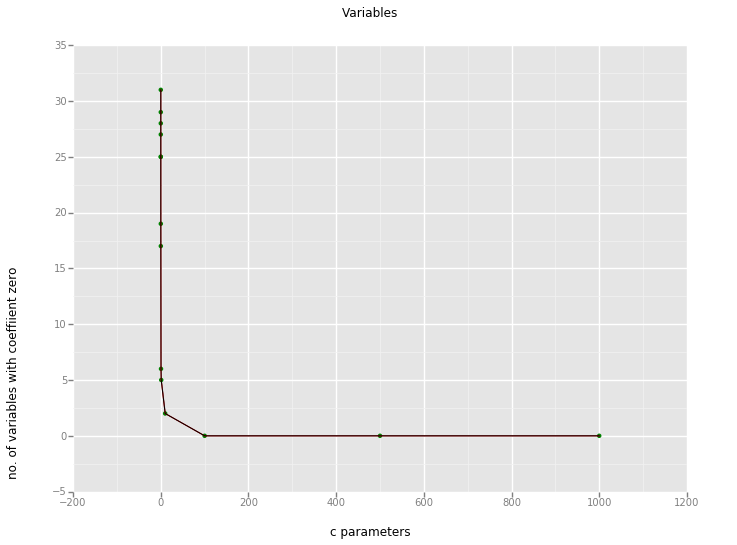

<ggplot: (151521991793)>

In [25]:
ggplot(aes(x="C_param",y="variables_with_coef_zero"),data=validation)+\
geom_point(color="green")+\
geom_line(color="red")+\
stat_smooth(method="loess",span=0.0)+\
xlab("c parameters") + ylab("no. of variables with coeffiient zero") + ggtitle("Variables")

C:\Users\Riya\AppData\Local\Continuum\Anaconda3\lib\site-packages\ggplot\stats\stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


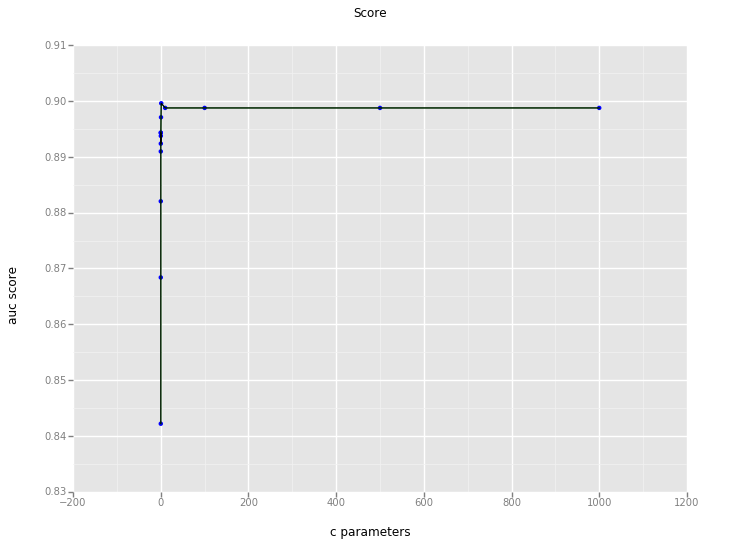

<ggplot: (151523194453)>

In [26]:
ggplot(aes(x="C_param",y="a_score"),data=validation)+\
geom_point(color="blue")+\
geom_line(color="green")+\
stat_smooth(method="loess",span=0.0)+\
xlab("c parameters") + ylab("auc score") + ggtitle("Score")

Two separate plots have been plotted just to avoid any confusion as the scales of both the variables are different.
From the plots you can see that as the C value decreases , number of variables with zero coefficient increses but the auc score decreases. So the C parameter is chosen in such a way that it should not penalize either to an extreme.

## Question 3. 

Build logistic regression model with l2 penalty and best value of penalty C. Find out auc score on test
data for the same.

In [27]:
#finding out the best parameter for logistic using l2 penalty
C_param =[0.0001,0.0002,0.0005,0.001,0.005,0.01,0.05, 0.1,0.5, 1, 10, 100,500,1000] 
auc_10cv=[]
for c in C_param:
    logr=LogisticRegression(C=c,penalty="l2",class_weight="balanced",random_state=2)
    kf = KFold(len(x_train), n_folds=10)
    score_c=0
    for train, test in kf:
        logr.fit(x_train.loc[train], y_train[train])
        score_c+=roc_auc_score(y_train,logr.predict(x_train))
    auc_10cv.append(score_c/10)
    print('{:.3f}\t {:.5f}\t '.format(c,score_c/10))
C_param=np.array(C_param)
auc_10cv=np.array(auc_10cv)
best_c=C_param[auc_10cv==max(auc_10cv)][0]
print('Value of C with max AUC score:',max(auc_10cv),' for 10 fold CV is :',best_c )

0.000	 0.90573	 
0.000	 0.90578	 
0.001	 0.90545	 
0.001	 0.90556	 
0.005	 0.90626	 
0.010	 0.90595	 
0.050	 0.90585	 
0.100	 0.90601	 
0.500	 0.90608	 
1.000	 0.90616	 
10.000	 0.90649	 
100.000	 0.90659	 
500.000	 0.90655	 
1000.000	 0.90661	 
Value of C with max AUC score: 0.906606634287  for 10 fold CV is : 1000.0


In [32]:
logr=LogisticRegression(C=best_c,penalty="l2",class_weight="balanced",random_state=2)

In [33]:
logr.fit(x_train,y_train)

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=2,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [34]:
roc_auc_score(y_train,logr.predict(x_train))

0.90762421555553141

In [35]:
roc_auc_score(y_test,logr.predict(x_test))

0.89848505810736023

As compared to l2 penalty,l1 penalty gives better auc score in this case. 


<br><br>

Prepared By: Riya Agrawal(riya.agrawal@edvancer.in) and Lalit Sachan (lalit.sachan@edvancer.in)